# Solutions Assignment 8

## Imports

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage, ToTensor
from torchvision.transforms.functional import crop
from torch.utils.data import Dataset
import cv2
import numpy as np
from PIL import Image
import json
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm
from collections import defaultdict
from tbparse import SummaryReader
import torchgadgets as tg
tg.set_random_seed(42)

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

from pathlib import Path as P


from run import Trainer, Market1501

/home/user/denninge/anaconda3/envs/vision_lab/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Utility/Evaluation Functions

In [2]:
plt.style.use('seaborn-v0_8')

def smooth(f, K=5):
    """ Smoothing a function using a low-pass filter (mean) of size K """
    kernel = np.ones(K) / K
    f = np.concatenate([f[:int(K//2)], f, f[int(-K//2):]])  # to account for boundaries
    smooth_f = np.convolve(f, kernel, mode="same")
    smooth_f = smooth_f[K//2: -K//2]  # removing boundary-fixes
    return smooth_f

def visualize_progress(trainer, train_loss, val_loss):
    """ Visualizing loss and accuracy """
    fig, ax = plt.subplots(1,3)
    fig.set_size_inches(24,5)

    x_ticks_pos = np.arange(0, trainer.config['num_iterations']*(trainer.config['num_epochs']+1), trainer.config['num_iterations'])
    x_ticks = np.arange(0,trainer.config['num_epochs']+1)

    smooth_train = smooth(train_loss, 31)
    ax[0].plot(train_loss, c="blue", label="Loss", linewidth=3, alpha=0.5)
    ax[0].plot(smooth_train, c="red", label="Smoothed Loss", linewidth=3, alpha=1)
    ax[0].legend(loc="best")
    ax[0].set_xticks(x_ticks_pos, x_ticks)
    ax[0].set_xlabel("# Epoch")
    ax[0].set_ylabel("Loss")
    ax[0].set_yscale("linear")
    ax[0].set_title("Training Progress (linear)")
    
    ax[1].plot(train_loss, c="blue", label="Loss", linewidth=3, alpha=0.5)
    ax[1].plot(smooth_train, c="red", label="Smoothed Loss", linewidth=3, alpha=1)
    ax[1].legend(loc="best")
    ax[1].set_xticks(x_ticks_pos, x_ticks)
    ax[1].set_xlabel("# Epoch")
    ax[1].set_ylabel("Loss")
    ax[1].set_yscale("log")
    ax[1].set_title("Training Progress (log)")

    N_ITERS = len(val_loss)
    ax[2].plot(x_ticks_pos, val_loss, c="red", label="Loss", linewidth=3, alpha=0.5)
    ax[2].legend(loc="best")
    ax[2].set_xticks(x_ticks_pos, x_ticks)
    ax[2].set_xlabel("# Epoch")
    ax[2].set_ylabel("Loss")
    ax[2].set_title(f"Valid Progress")

    return

def compare_models(trainers: list, train_losses: list, val_losses: list, model_names: list):
    """ 
        Visualizing loss and accuracy and compare between multiple models.
    """
    fig, ax = plt.subplots(1,3)
    fig.set_size_inches(24,5)

    for i, train_loss in enumerate(train_losses):
        smooth_train = smooth(train_loss, 31)
        ax[0].plot(smooth_train, label=f"{model_names[i]} Loss", linewidth=1, alpha=1)
        ax[1].plot(smooth_train, label=f"{model_names[i]} Loss", linewidth=1, alpha=1)

    ax[0].legend(loc="best")
    ax[0].set_xlabel("# Iteration")
    ax[0].set_ylabel("Loss")
    ax[0].set_yscale("linear")
    ax[0].set_title("Training Progress (linear)")

    ax[1].legend(loc="best")
    ax[1].set_xlabel("# Epoch")
    ax[1].set_ylabel("Loss")
    ax[1].set_yscale("log")
    ax[1].set_title("Training Progress (log)")

    for i, val_loss in enumerate(val_losses):
        x_ticks_pos = np.arange(0, trainers[i].config['num_iterations']*(trainers[i].config['num_epochs']+1), trainers[i].config['num_iterations'])
        ax[2].plot(x_ticks_pos, val_loss, label=f"{model_names[i]} Loss", linewidth=1, alpha=1)
    ax[2].legend(loc="best")
    ax[2].set_xlabel("# Iteration")
    ax[2].set_ylabel("Loss")
    ax[2].set_title(f"Valid Progress")

    return

def display_projections(points, labels, ax=None, legend=None, limit_labels=15, images=None):
    """ Displaying low-dimensional data projections """

    COLORS = ['r', 'b', 'g', 'y', 'purple', 'orange', 'k', 'brown', 'grey',
              'c', "gold", "fuchsia", "lime", "darkred", "tomato", "navy"]

    unique_labels = list(np.unique(labels)[:limit_labels])
    legend = [f"Class {l}" for l in unique_labels] if legend is None else legend
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(36, 24))

    for i, l in enumerate(unique_labels):
        idx = np.where(l == labels)
        ax.scatter(points[idx, 0], points[idx, 1], label=legend[i], c=COLORS[i % len(COLORS)])

    if images is not None:
        for i, point in enumerate(points):
            xy = [point[0], point[1]]
            arr_img = images[i]
            # Convert arr_img to grayscale
            arr_img = ToPILImage()(arr_img)
            l = labels[i]
            if l in unique_labels:
                imagebox = OffsetImage(arr_img, zoom=1)
                imagebox.image.axes = ax
                ab = AnnotationBbox(imagebox, xy,
                                    xybox=(0, 0),
                                    xycoords='data',
                                    boxcoords="offset points",
                                    pad=0.1,
                                    bboxprops=dict(edgecolor=COLORS[unique_labels.index(l)], lw=2)
                                    )
                ax.add_artist(ab)

    # Move the legend outside the figure
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


def load_tensorboard_logs(exp_name, run_name):
    """
        Load the TensorBoard logs from the log files and extract the training and validation loss.
    """
    log_dir = P(os.getcwd(), 'experiments', exp_name, run_name, 'logs')
    reader = SummaryReader(log_dir, pivot=True)
    train_data = reader.scalars
    train_loss = train_data.loc[:,'iteration_metrics/train/loss'].to_numpy().astype(float)
    test_loss = train_data.loc[:,'epoch_metrics/test/loss'].to_numpy().astype(float)
    train_loss = train_loss[~np.isnan(train_loss)]
    test_loss = test_loss[~np.isnan(test_loss)]
    return train_loss, test_loss

def visualize_dataset(meta_dir, is_train=True, layout=(4,4)):
    """
        Simple visualization of the dataset
    """
    NUM_IMG = layout[0]*layout[1]
    num_img_pp = layout[0]
    num_persons = layout[1]

    dataset_path = "data/Market-1501/bounding_box_train" if is_train else "data/Market-1501/bounding_box_test"
    person_ids = list(meta_dir.keys())
    np.random.shuffle(person_ids)

    fig, ax = plt.subplots(layout[0], layout[1])
    fig.set_size_inches(3 * layout[1], 3 * layout[0])

    offset = 0

    for x in range(num_persons):
        label = person_ids[x+offset]
        img_paths = list(meta_dir[label].values())
        while len(img_paths) < NUM_IMG:
            offset += 1
            label = person_ids[x+offset]
            img_paths = list(meta_dir[label].values())
        np.random.shuffle(img_paths)
        for y in range(num_img_pp):
            img_path = os.path.join(dataset_path, img_paths[y])
            img = Image.open(img_path)
            ax[y][x].imshow(img)
            ax[y][x].axis('off')
            ax[y][x].set_title(f"Label: {label}", fontsize=10)
            
def get_images_from_dataset(meta_dir, n_labels: int, is_train=True, labels: list = None, min_imgs: int = None):
    """
        Function to load images from one class for evaluation.
        It returns a list of torch.Tensors with each element of the list representing the images for a given label.
        If no labels are provided random labels are chosen.
    """
    dataset = Market1501(is_train=is_train, transforms=tv.transforms.ToTensor())
    if labels is None:
        labels = list(meta_dir.keys())
        np.random.shuffle(labels)
    
    offset = 0
    class_imgs = []
    classes_list = []

    for n in range(n_labels):
        label = labels[n+offset]
        img_ids = list(meta_dir[label].keys())
        imgs = []
        classes = []
        while min_imgs is not None and len(img_ids) < min_imgs:
            offset += 1
            label = labels[n+offset]
            img_ids = list(meta_dir[label].keys())
        for id in img_ids:
            img, _ = dataset[int(id)]
            imgs.append(img)
            classes.append(int(label))
        imgs = torch.stack(imgs)
        classes = torch.Tensor(classes).to(dtype=int)
        class_imgs.append(imgs)
        classes_list.append(classes)
        

    return class_imgs, classes_list
            
   
def compute_model_embedding(trainer, images):
    """
        Compute the embedding vector for a batch of images given the trainer module.
    """

    embedding_vectors = []
    for img_tensor in images:
        class_embedding = trainer.get_embedding_vector(img_tensor)
        embedding_vectors.append(class_embedding)

    return embedding_vectors

def cluster_evaluation(inputs, labels, images=None):
    """
        Evaluate the the embedding using PCA/T-SNE projections onto the two-dimensional plane.
    """
    pca_imgs = PCA(n_components=2).fit_transform(inputs)
    tsne_imgs = TSNE(n_components=2).fit_transform(inputs)

    plt.style.use('seaborn-v0_8')
    fig,ax = plt.subplots(1,2,figsize=(26,8))
    display_projections(pca_imgs, labels, ax=ax[0], legend=None, limit_labels=16, images=images)
    ax[0].set_title("PCA Projection")
    display_projections(tsne_imgs, labels, ax=ax[1], legend=None, limit_labels=16, images=images)
    ax[1].set_title("T-SNE Projection")
    
def compute_ari_scores(input, labels):
    """ Compute the ARI score"""
    kmeans = KMeans(n_clusters=10, random_state=0).fit(input)
    ari = adjusted_rand_score(labels, kmeans.labels_)
    return ari


## Dataset

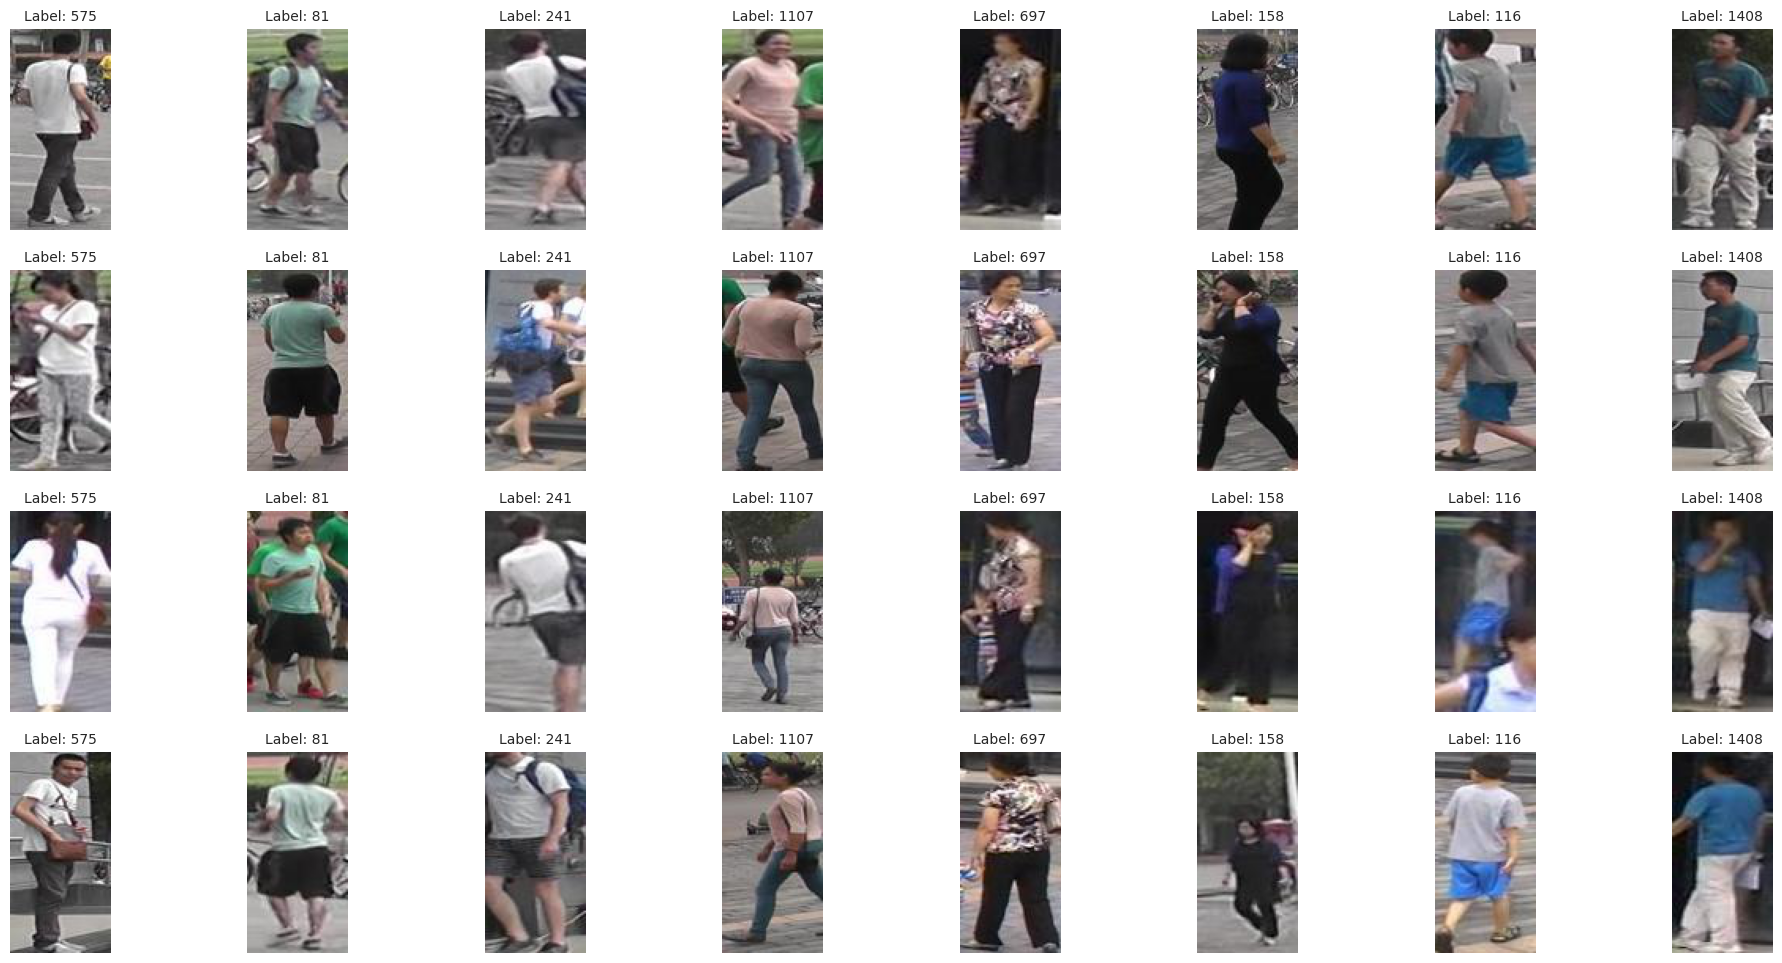

In [3]:
with open('data/Market-1501/train_meta_dir.json', 'r') as f:
    train_set_meta_dir = json.load(f)

with open('data/Market-1501/test_meta_dir.json', 'r') as f:
    test_set_meta_dir = json.load(f)

visualize_dataset(train_set_meta_dir, layout=(4,8))

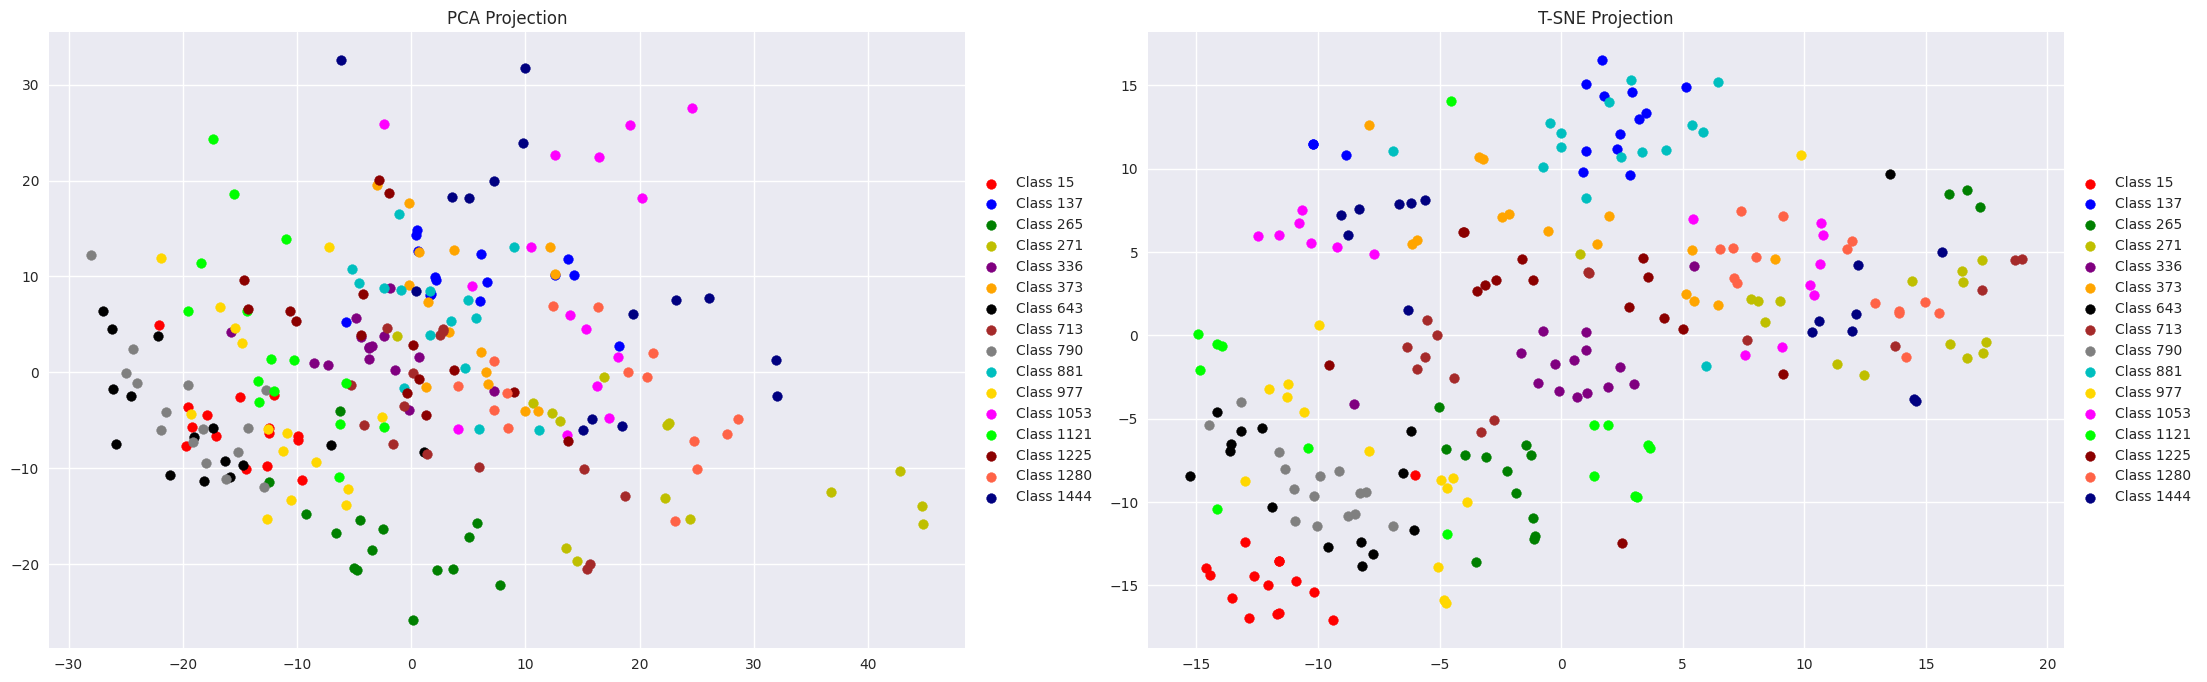

In [4]:

###--- Sampling of images for Evaluation ---###
NUM_CLASSES = 16
NUM_IMGS_PER_CLASS = 15

eval_imgs, eval_labels = get_images_from_dataset(test_set_meta_dir, NUM_CLASSES, is_train=False, min_imgs=NUM_IMGS_PER_CLASS)
eval_imgs = [img[:NUM_IMGS_PER_CLASS] for img in eval_imgs]
eval_labels = [lbl[:NUM_IMGS_PER_CLASS] for lbl in eval_labels]

lbls_flatten = np.concatenate([lbl.numpy() for lbl in eval_labels], axis=0).flatten()

imgs_flatten = [torch.flatten(img, start_dim=1, end_dim=-1).numpy() for img in eval_imgs]
imgs_flatten = np.concatenate(imgs_flatten, axis=0)

# Generate pca embeddings for model without pretraining
pca_class_imgs = []

cluster_evaluation(imgs_flatten, lbls_flatten)

## ResNet-18 Pre-trained

In [5]:
exp_name = "resnet18_pretrained"
run_name = "run_1"
epoch = 20

pre_trained_trainer = Trainer(exp_name, run_name, logging=False)
pre_trained_trainer.load_checkpoint(epoch)

pre_trained_train_loss, pre_trained_test_loss = load_tensorboard_logs(exp_name, run_name)

Model checkpoint was load from: /home/user/denninge/VisionLabSS23/Assignments_8/experiments/resnet18_pretrained/run_1/checkpoints/checkpoint_20.pth


In [6]:
pre_trained_trainer.model

SiameseModel(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

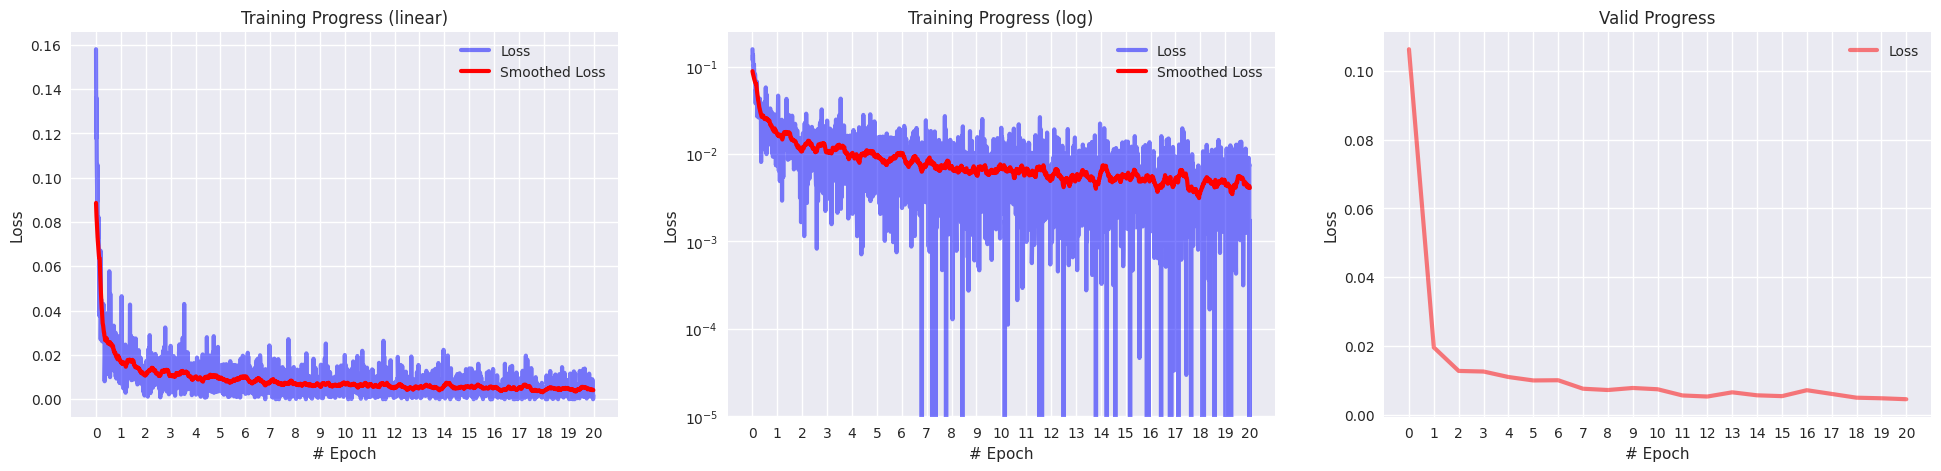

In [7]:
visualize_progress(pre_trained_trainer, pre_trained_train_loss, pre_trained_test_loss)

## ResNet-18 "From Scratch"

In [8]:
exp_name = "resnet18_scratch"
run_name = "run_1"
epoch = 20

scratch_trainer = Trainer(exp_name, run_name, logging=False)
scratch_trainer.load_checkpoint(epoch)

scratch_train_loss, scratch_test_loss = load_tensorboard_logs(exp_name, run_name)

Model checkpoint was load from: /home/user/denninge/VisionLabSS23/Assignments_8/experiments/resnet18_scratch/run_1/checkpoints/checkpoint_20.pth


In [9]:
scratch_trainer.model

SiameseModel(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

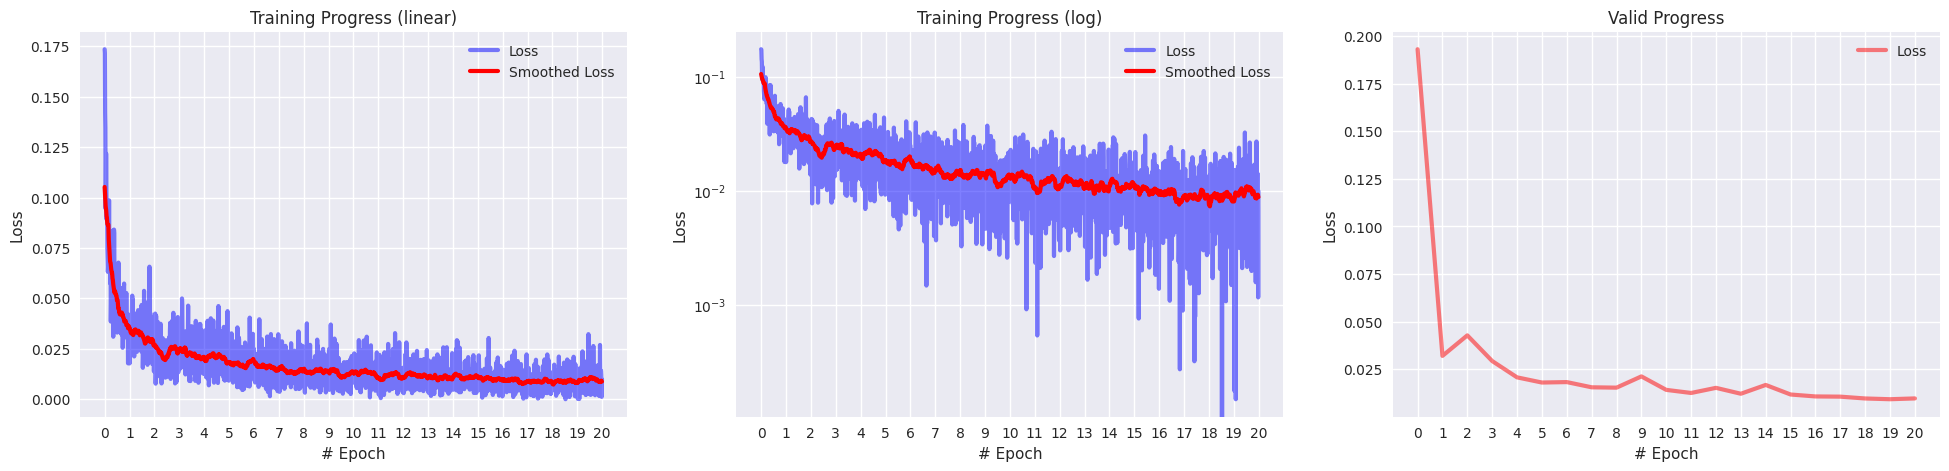

In [10]:
visualize_progress(scratch_trainer, scratch_train_loss, scratch_test_loss)

## Comparison: "From Scratch" vs Pre-Trained

Eventhough the pre-trained model seems to achieve a slightly lower loss on both the train and test set the ARI score is higher for the model trained from scratch. From a visual inspection of the embedding visualizations, we conclude that the model trained from scratch produces a more disentangelt representation. A reason for this could be that the pre-trained model uses learned features from the ImageNet-1k dataset, which consists of images from a large variaty of objects, that do not transfer well to our task. For the following task we therefore chose to train our model from scratch.

### Pre-Trained Embeddings

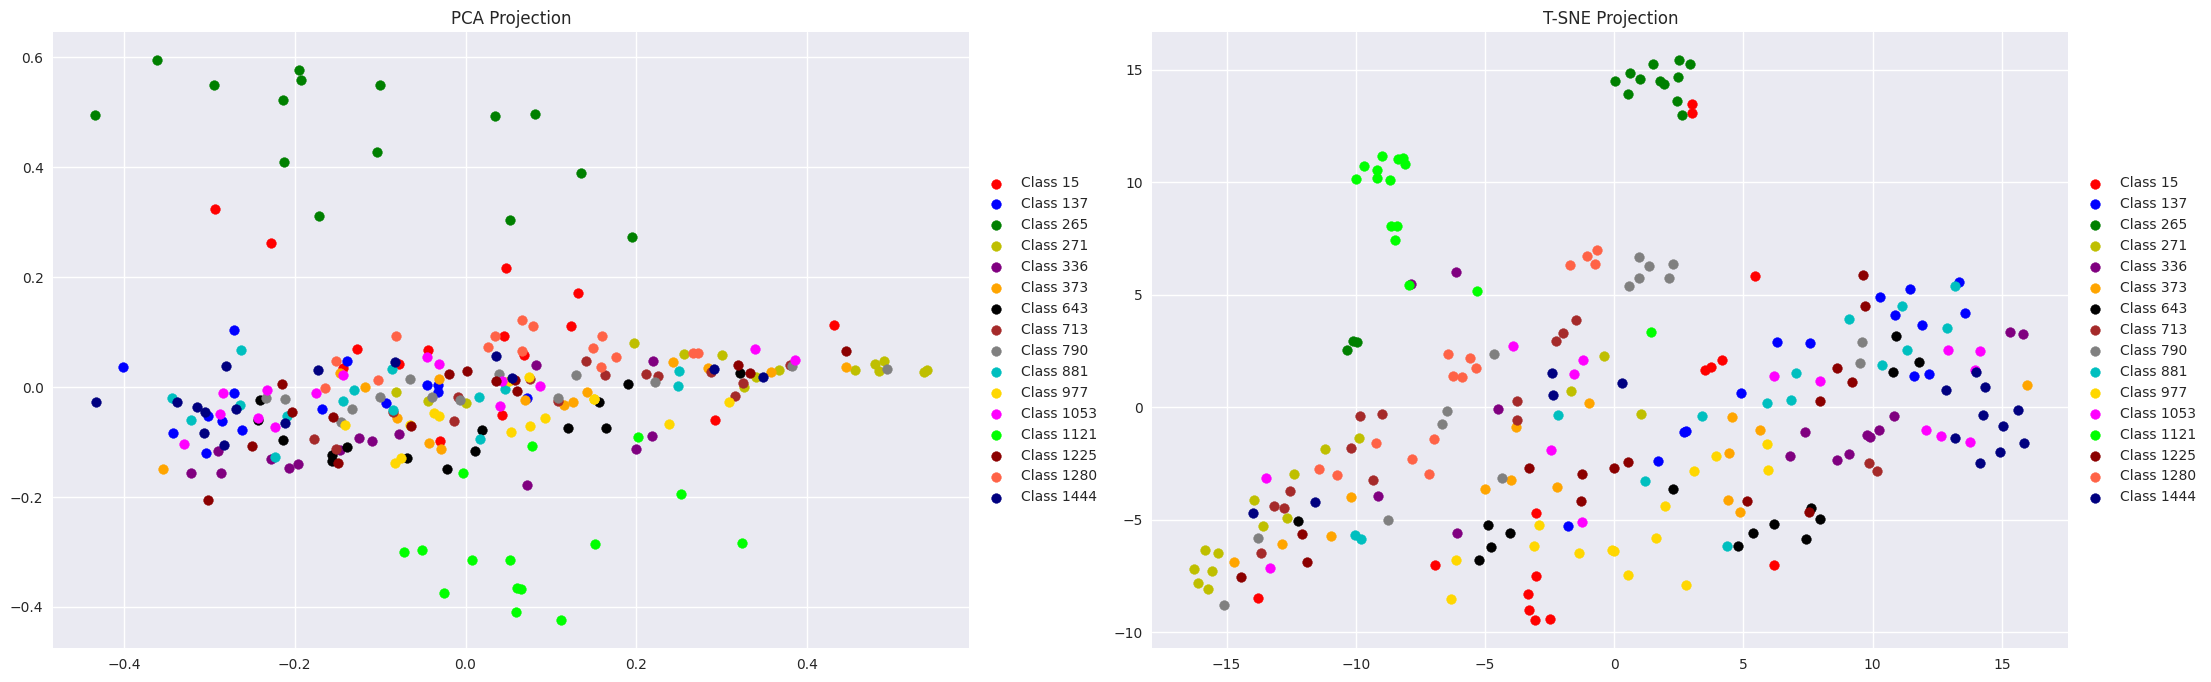

In [11]:
model_emb = compute_model_embedding(pre_trained_trainer, eval_imgs)
pre_trained_model_emb = torch.flatten(torch.stack(model_emb, dim=0), start_dim=0, end_dim=1).numpy()
cluster_evaluation(pre_trained_model_emb, lbls_flatten)

### From Scratch Embeddings

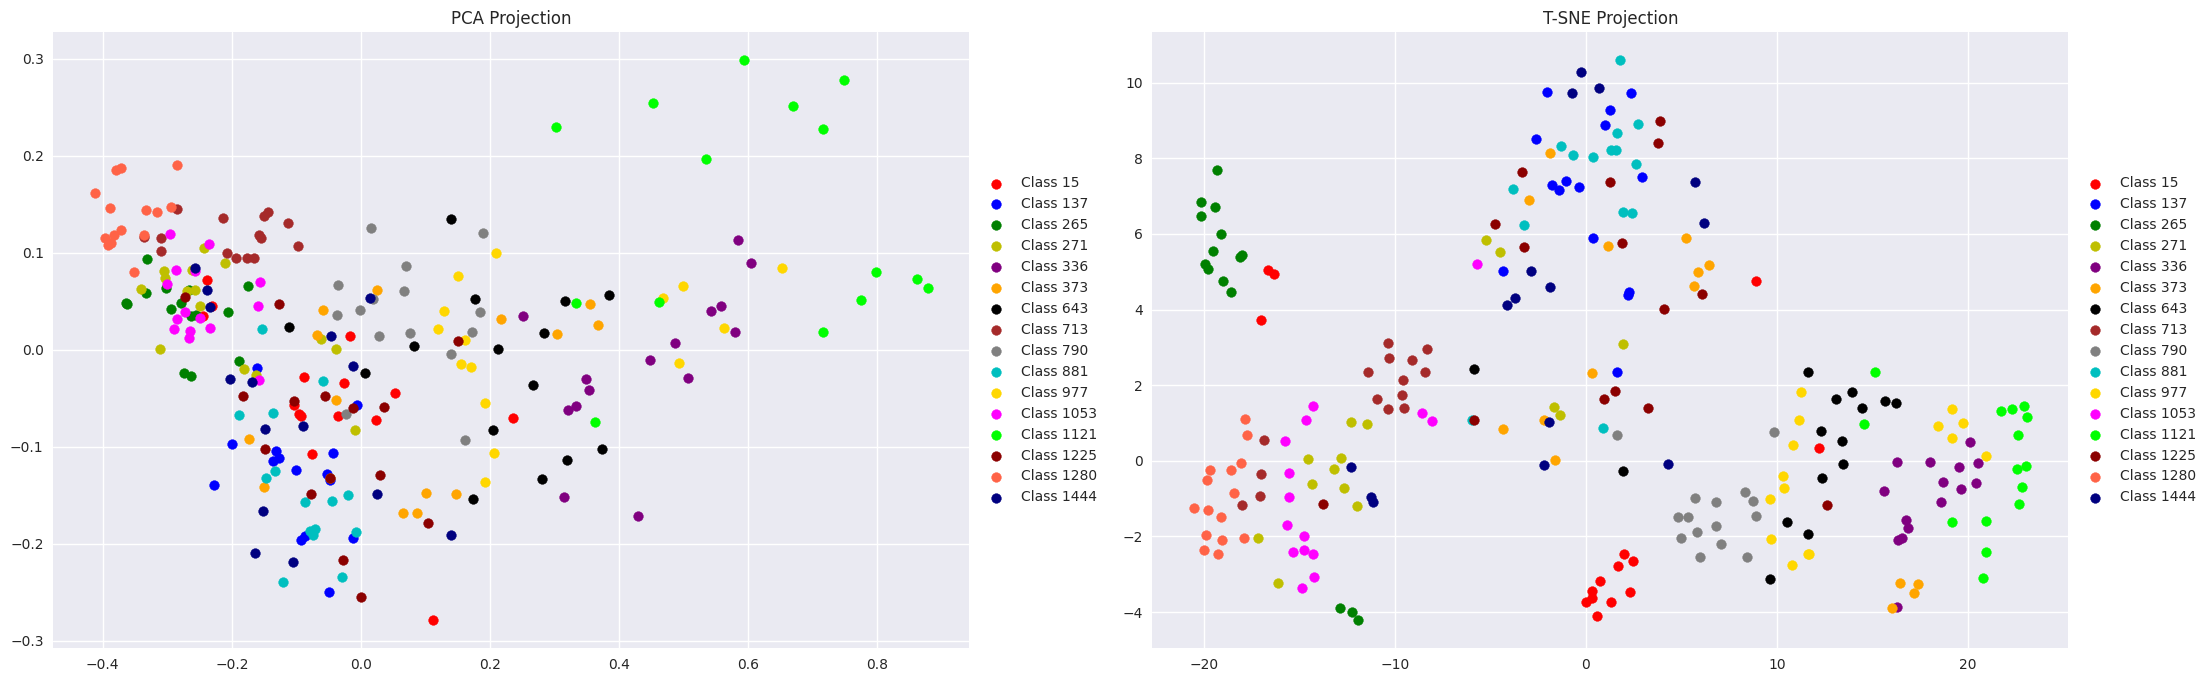

In [12]:
model_emb = compute_model_embedding(scratch_trainer, eval_imgs)
scratch_model_emb = torch.flatten(torch.stack(model_emb, dim=0), start_dim=0, end_dim=1).numpy()
cluster_evaluation(scratch_model_emb, lbls_flatten)

### Training Progress

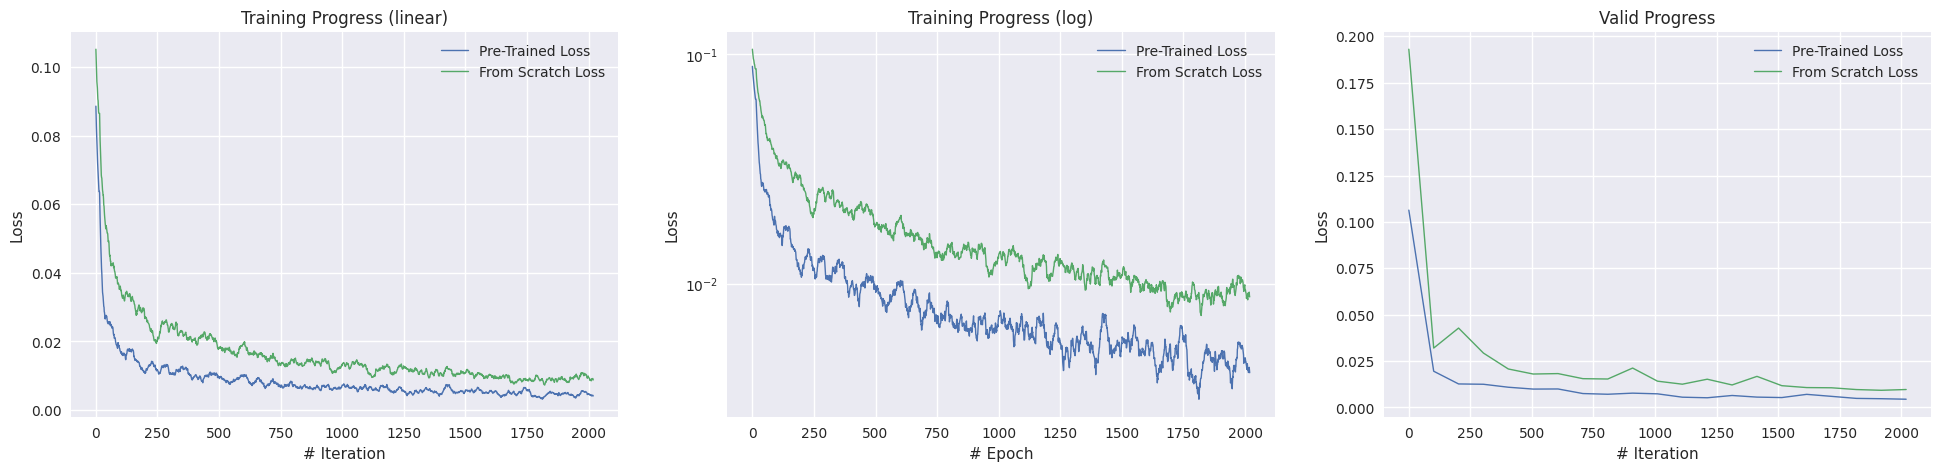

In [13]:
compare_models([pre_trained_trainer, scratch_trainer], [pre_trained_train_loss, scratch_train_loss], [pre_trained_test_loss, scratch_test_loss], ["Pre-Trained", "From Scratch"])

### ARI

In [14]:
pre_trained_ari = compute_ari_scores(pre_trained_model_emb, lbls_flatten)
scratch_ari = compute_ari_scores(scratch_model_emb, lbls_flatten)

print(f"ARI Scores:\n Pre-trained model: {pre_trained_ari:.4f}\n From Scratch model: {scratch_ari:.4f}")

ARI Scores:
 Pre-trained model: 0.1612
 From Scratch model: 0.2528


/home/user/denninge/anaconda3/envs/vision_lab/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/user/denninge/anaconda3/envs/vision_lab/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## ResNet-18 with Semi-hard Negative Mining


In [15]:
exp_name = "resnet18_mining"
run_name = "run_2"
epoch = 40

mining_trainer = Trainer(exp_name, run_name, logging=False)
mining_trainer.load_checkpoint(epoch)

mining_train_loss, mining_test_loss = load_tensorboard_logs(exp_name, run_name)

Model checkpoint was load from: /home/user/denninge/VisionLabSS23/Assignments_8/experiments/resnet18_mining/run_2/checkpoints/checkpoint_40.pth


In [16]:
mining_trainer.model

SiameseModel(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

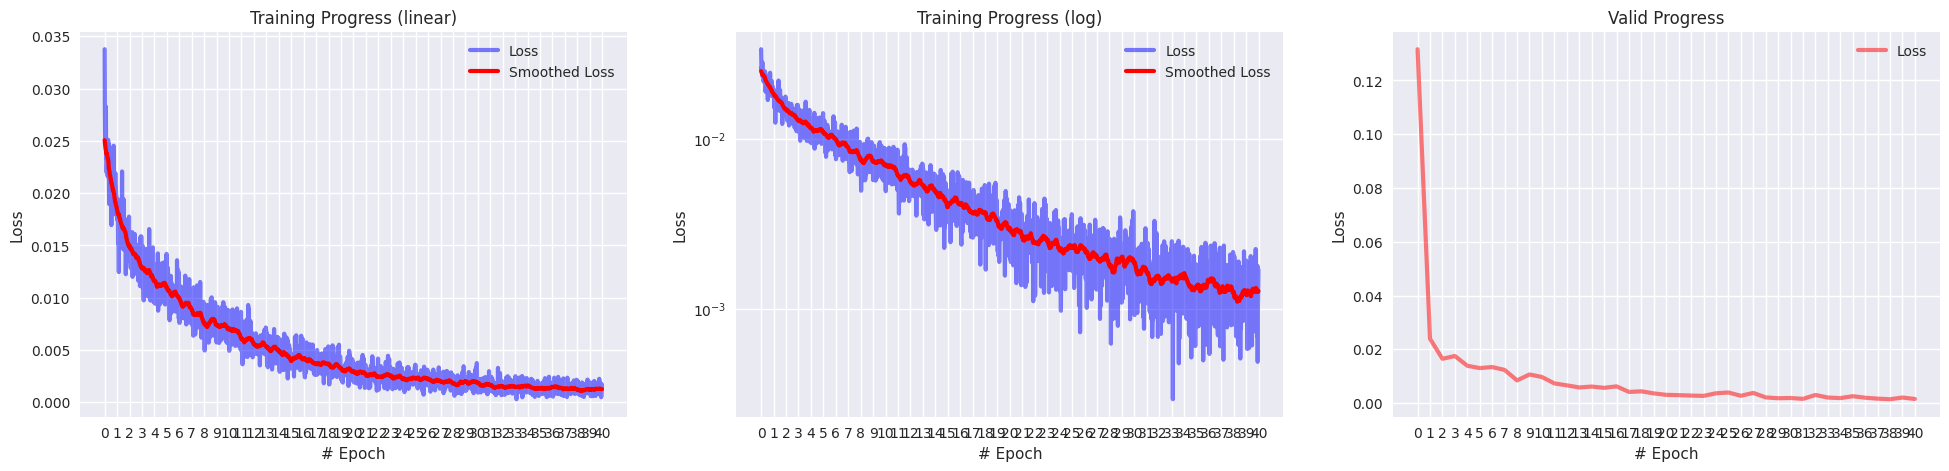

In [17]:
visualize_progress(mining_trainer, mining_train_loss, mining_test_loss)

## Comparison: With Mining vs. Without Mining
Using the semi-hard negative mining strategy to choose negative exampled lead to i significant decrease in the training and evaluation loss. The embedding visualization shows that the more elaborate choice of a negative example leads to more disentangelt representation. Using the T-SNE projection onto the two-dimensional plane, we achieve well-separated clusters. The ARI score was boosted by a factor of 2 as promised in the last session.

### Without Mining Embeddings

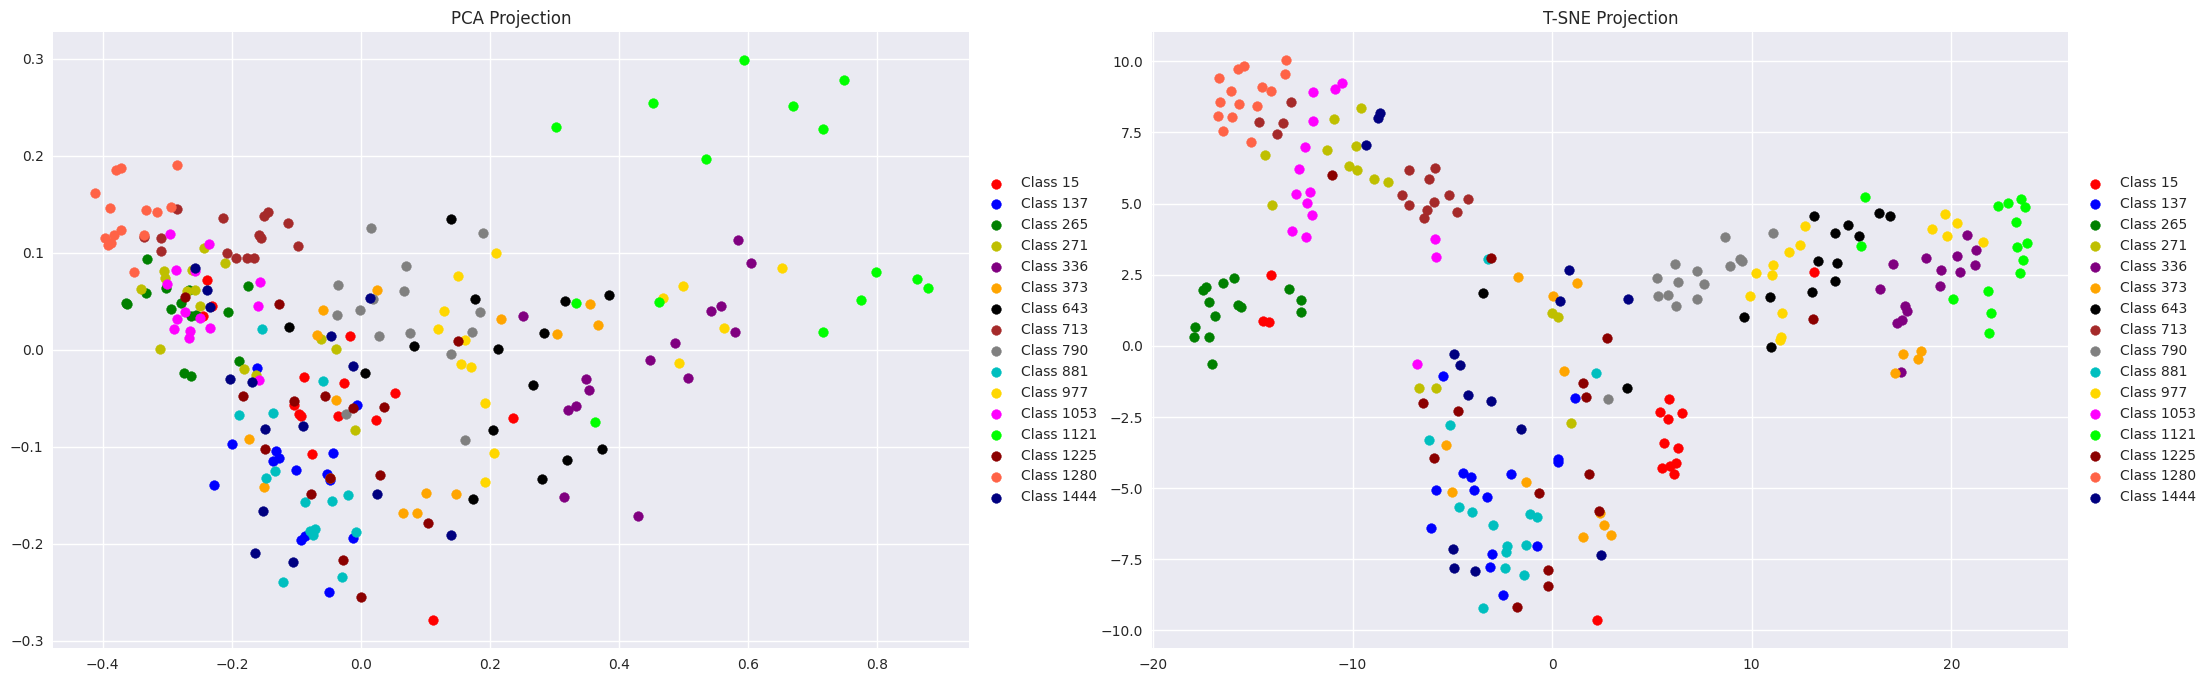

In [18]:
cluster_evaluation(scratch_model_emb, lbls_flatten)

### With Mining Embeddings

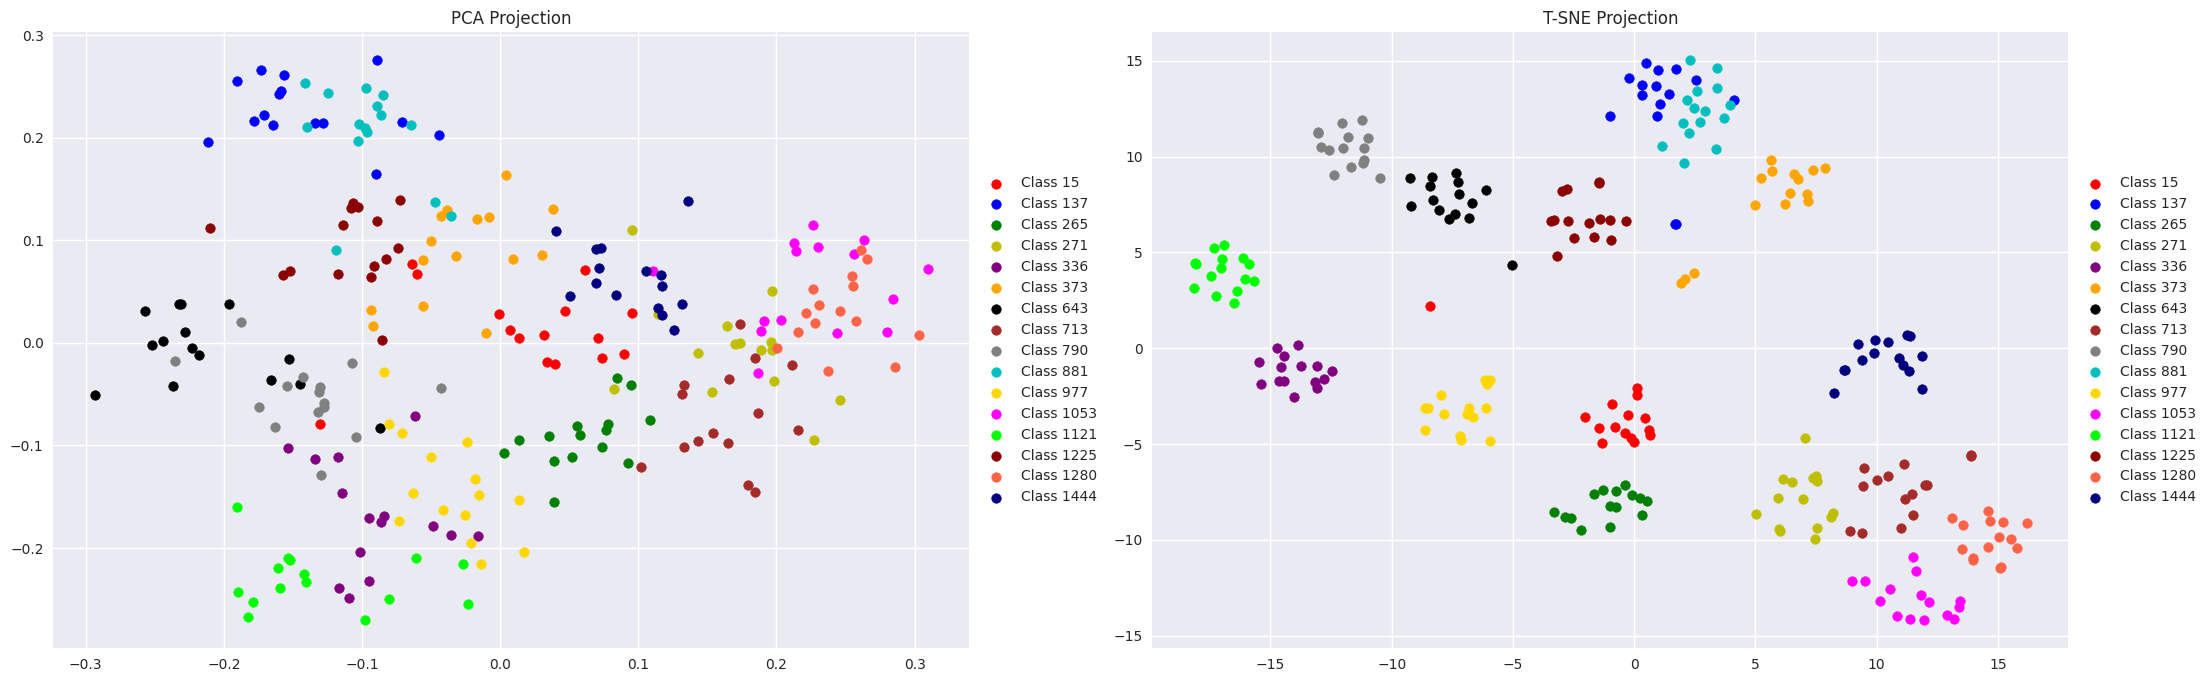

In [19]:
model_emb = compute_model_embedding(mining_trainer, eval_imgs)
mining_model_emb = torch.flatten(torch.stack(model_emb, dim=0), start_dim=0, end_dim=1).numpy()
cluster_evaluation(mining_model_emb, lbls_flatten)

### Training Progress

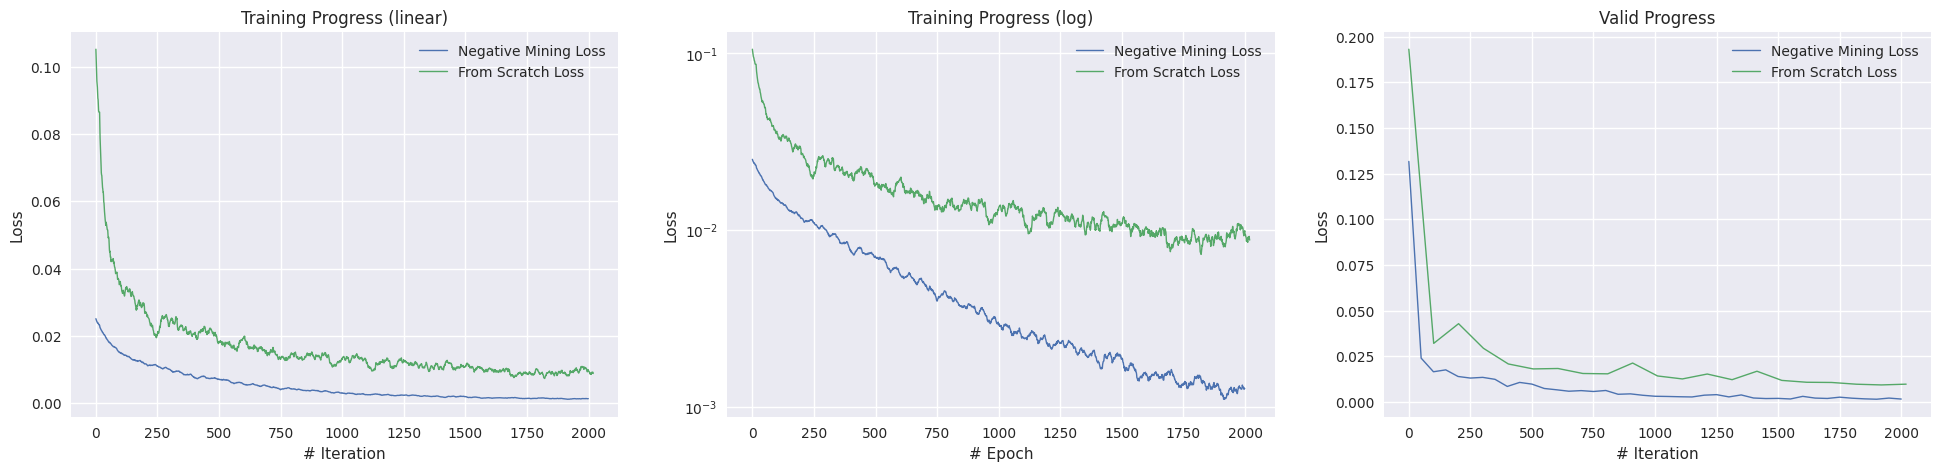

In [20]:
compare_models([mining_trainer, scratch_trainer], [mining_train_loss, scratch_train_loss], [mining_test_loss, scratch_test_loss], ["Negative Mining", "From Scratch"])


### ARI Score

In [21]:
mining_ari = compute_ari_scores(mining_model_emb, lbls_flatten)

print(f"ARI Scores:\n From Scratch model: {scratch_ari:.4f}\n Mining model: {mining_ari:.4f}")

ARI Scores:
 From Scratch model: 0.2528
 Mining model: 0.6086


/home/user/denninge/anaconda3/envs/vision_lab/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## ResNet-18 with Angular Loss

In [22]:
exp_name = "resnet18_angular"
run_name = "run_1"
epoch = 40

angular_trainer = Trainer(exp_name, run_name, logging=False)
angular_trainer.load_checkpoint(epoch)

angular_train_loss, angular_test_loss = load_tensorboard_logs(exp_name, run_name)

Model checkpoint was load from: /home/user/denninge/VisionLabSS23/Assignments_8/experiments/resnet18_angular/run_1/checkpoints/checkpoint_40.pth


In [23]:
mining_trainer.model

SiameseModel(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

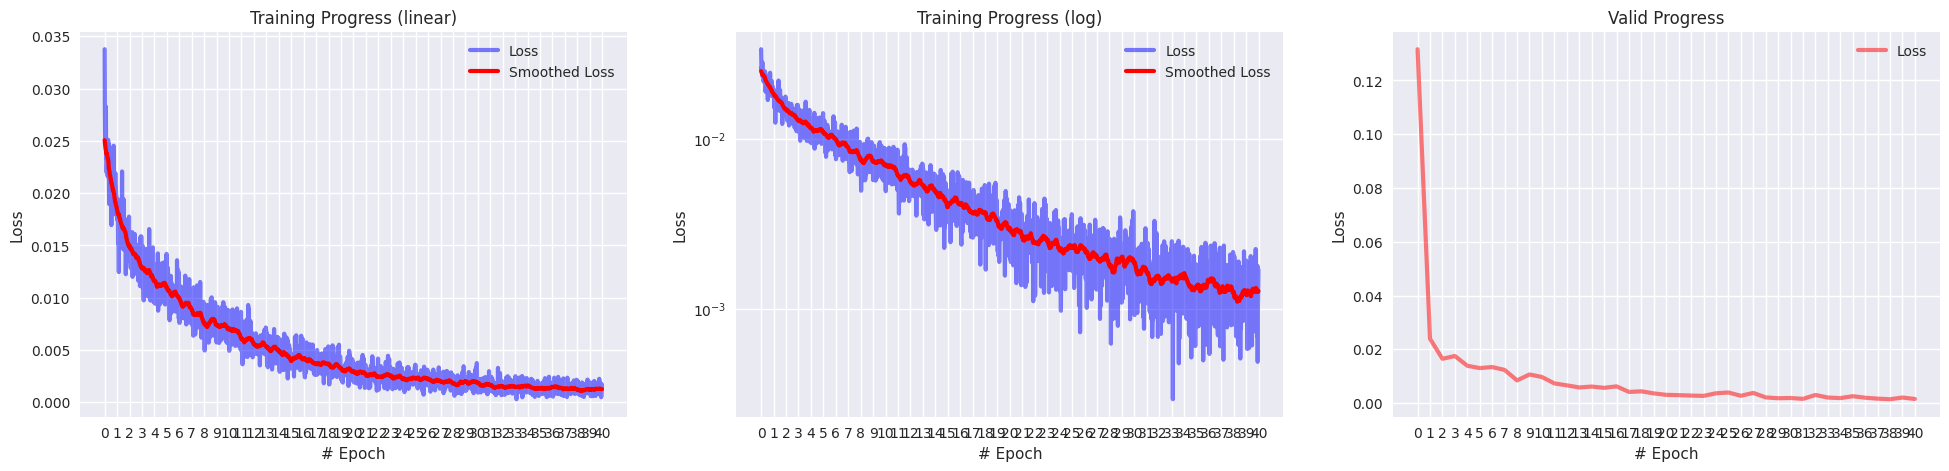

In [24]:
visualize_progress(mining_trainer, mining_train_loss, mining_test_loss)

## ResNet-18 with N-Pair Loss

## Comparison: Different Loss Functions

### Triplet Loss Embedding

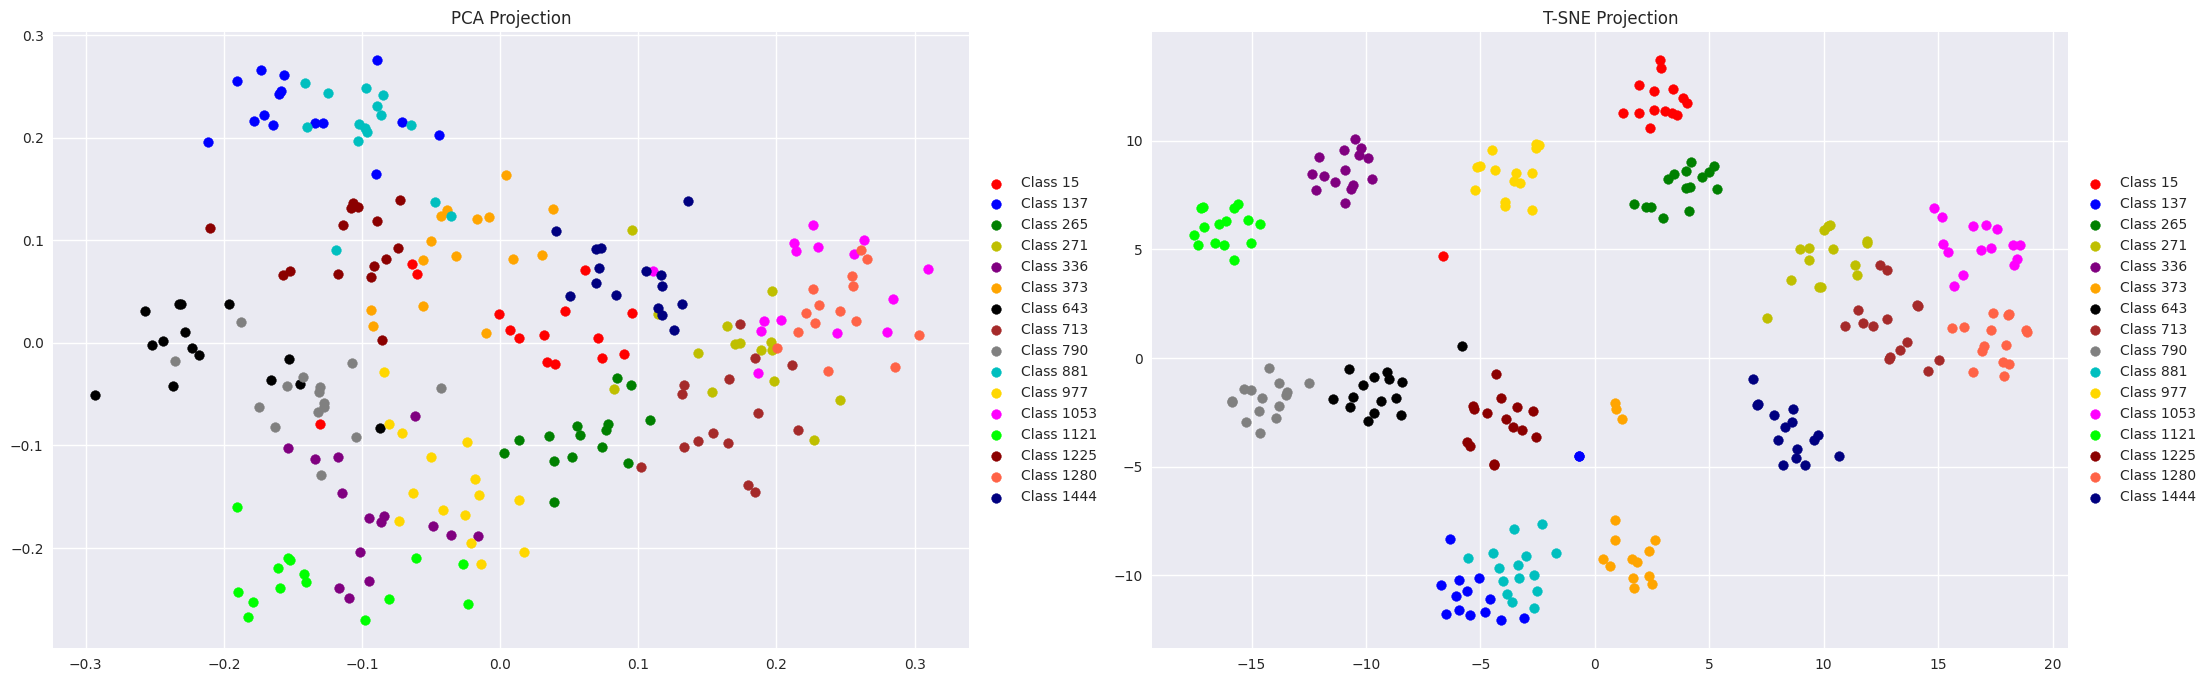

In [25]:
cluster_evaluation(mining_model_emb, lbls_flatten, )


### Angular Loss Embedding

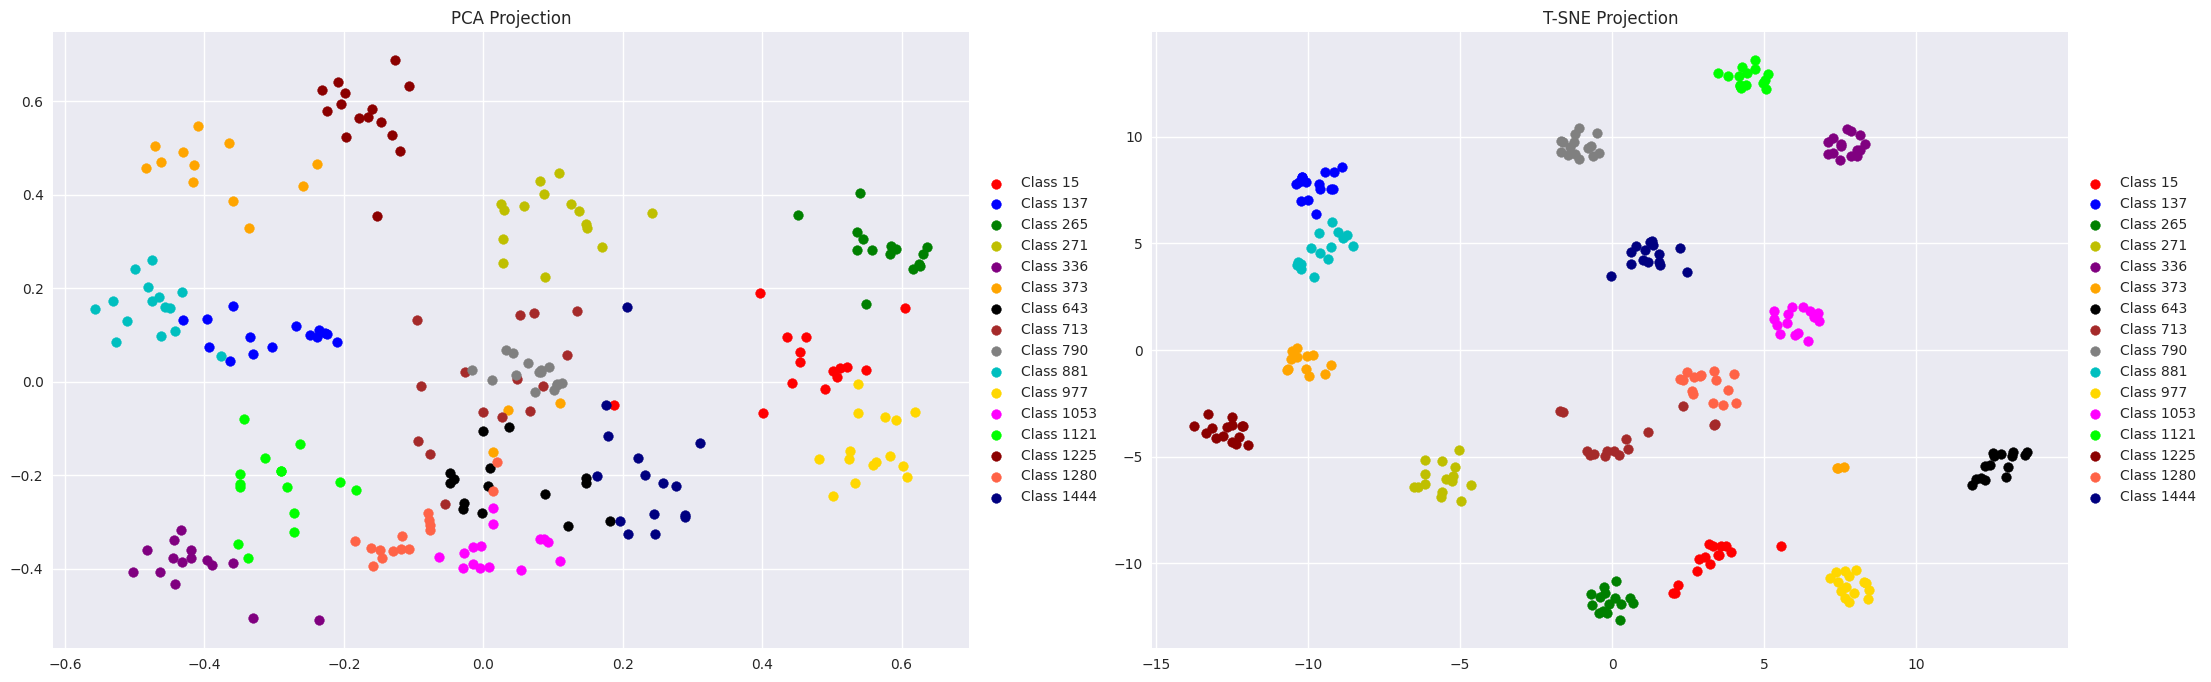

In [27]:
model_emb = compute_model_embedding(angular_trainer, eval_imgs)
angular_model_emb = torch.flatten(torch.stack(model_emb, dim=0), start_dim=0, end_dim=1).numpy()
cluster_evaluation(angular_model_emb, lbls_flatten)